In [12]:
import matplotlib.pyplot as plt
import numpy as np
from exotic_ld import StellarLimbDarkening
from astropy.modeling.fitting import LevMarLSQFitter
import lmfit
from scipy import stats
from astropy.io import fits
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker
import batman 
import xarray as xr
import netCDF4
import h5netcdf
import json
from astropy.utils.misc import JsonCustomEncoder
import os
import pandas as pd
from functools import partial

In [ ]:
#get the wavelength ranges for bins
bins = pd.read_csv('TOI134_01_60pix_bins.txt', skiprows=1, sep=' ', names=['short', 'long', 'center', 'width'])

In [ ]:
# specify the file name, path, save path, and information about the target 
spec_file = 'toi134b-nrs1.xc'
name=spec_file.split('.')[0]
lc_dir = './speclcs/'

if os.path.isdir('./outputs/'+name) is False:
    os.mkdir('./outputs/'+name)
save_dir = './outputs/'+name+'/'

grating = 'G395H' 
ld_model = 'mps1'
ld_type = 'nonlinear'
# ld_type = 'quadratic'

'''parameters for limb darkening calculations'''
Teff = 3842  
logg = 4.84 
M_H = -.03 #metallicity

'''transit parameters'''  #using parameters consistent with MIRI results 
T0       = 60113.88027683486           # BJD time of inferior conjunction
period   = 1.401526                        # orbital period (days) BJD_TDB
Rp       = 0.025738585287486525                 # planet radius (in units of stellar radii)
aRs      = 4.005871895235393              # semi-major axis (input a/Rs so units of stellar radii) 
inc      = 77.00902477777493            # orbital inclination
ecc      = 0.0                              # eccentricity
omega    = 0                             # longitude of periastron

rho_star = (3*np.pi)/(6.67259e-8*(period*86400)**2)*(aRs)**3     # stellar density (g/cm^3) from a/Rs

In [16]:
def get_wlc(filename):
    '''
    Read in white light curve 
    
    ======
    INPUT: 
    ======
    - filename for xarray file

    ======    
    OUTPUT: 
    ======
    - time (BJD_TDB), raw_flux, raw_flux_error, 
    shift_x, shift_y
    '''
    
    #read in xarray file
    ds = xr.open_dataset(lc_dir+filename, engine='h5netcdf')
    
    #pull out arrays
    times = ds['time_flux'].values
    flux = ds['flux'].values
    flux_err = ds['flux_error'].values
    # flux = np.sum(ds['flux'].values, axis=0)
    # flux_err = np.sum(ds['flux_error'].values, axis=0)
    x = ds['x'].values
    y = ds['y'].values
    quality_flag = ds['quality_flag'].values
    binstart = ds['bin_starts'].values
    binend = ds['bin_ends'].values

    return times,flux,flux_err,x,y,quality_flag,binstart,binend

In [18]:
def noise_calculator(data,wl1_nrs1,wl2_nrs1,maxnbins=None,binstep=1):
    """
    Author: Hannah R. Wakeford, University of Bristol
    Email: hannah.wakeford@bristol.ac.uk
    Citation: Laginja & Wakeford, 2020, JOSS, 5, 51 (https://joss.theoj.org/papers/10.21105/joss.02281)
    
    Calculate the noise parameters of the data by using the residuals of the fit
    :param data: array, residuals of (2nd) fit
    :param maxnbins: int, maximum number of bins (default is len(data)/10)
    :param binstep: bin step size
    :return:
        red_noise: float, correlated noise in the data
        white_noise: float, statistical noise in the data
        beta: float, scaling factor to account for correlated noise
    """

    plt.rcParams['figure.figsize'] = [10.0, 7.0] 

    # bin data into multiple bin sizes
    npts = len(data)
    if maxnbins is None:
        maxnbins = npts/10.

    # create an array of the bin steps to use
    binz = np.arange(1, maxnbins+binstep, step=binstep, dtype=int)

    # Find the bin 2/3rd of the way down the bin steps
    midbin = int((binz[-1]*2)/3)

    nbins = np.zeros(len(binz), dtype=int)
    standard_dev = np.zeros(len(binz))
    root_mean_square = np.zeros(len(binz))
    root_mean_square_err = np.zeros(len(binz))
    
    for i in range(len(binz)):
        nbins[i] = int(np.floor(data.size/binz[i]))
        bindata = np.zeros(nbins[i], dtype=float)
        
        # bin data - contains the different arrays of the residuals binned down by binz
        for j in range(nbins[i]):
            bindata[j] = np.mean(data[j*binz[i] : (j+1)*binz[i]])

        # get root_mean_square statistic
        root_mean_square[i] = np.sqrt(np.mean(bindata**2))
        root_mean_square_err[i] = root_mean_square[i] / np.sqrt(2.*nbins[i])
      
    expected_noise = (np.std(data)/np.sqrt(binz)) * np.sqrt(nbins/(nbins - 1.))
 
    final_noise = np.mean(root_mean_square[midbin:])
    base_noise = np.sqrt(final_noise**2 - root_mean_square[0]**2 / nbins[midbin])

    # Calculate the random noise level of the data
    white_noise = np.sqrt(root_mean_square[0]**2 - base_noise**2)
    # Determine if there is correlated noise in the data
    red_noise = np.sqrt(final_noise**2 - white_noise**2 / nbins[midbin])
    # Calculate the beta scaling factor
    beta = np.sqrt(root_mean_square[0]**2 + nbins[midbin] * red_noise**2) / root_mean_square[0]

    # If White, Red, or Beta return NaN's replace with 0, 0, 1
    white_noise = np.nan_to_num(white_noise, copy=True)
    red_noise = np.nan_to_num(red_noise, copy=True)
    beta = 1 if np.isnan(beta) else beta
    
    # Plot up the bin statistic against the expected statistic
    # This can be used later when we are setting up unit testing.
    plt.figure()
    plt.errorbar(binz, root_mean_square, yerr=root_mean_square_err, color='gray', lw=1.5, label='RMS')
    plt.plot(binz, expected_noise, color='purple', ls='-', lw=2, label='expected noise')
    
    plt.title('Expected vs. measured noise binning statistic ({}-{})'.format(wl1_nrs1,wl2_nrs1))
    plt.xlabel('Number of bins',fontsize=14)
    plt.ylabel('RMS',fontsize=14)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(save_dir+'RMS_bins_{}-{}.pdf'.format(wl1_nrs1,wl2_nrs1))
    plt.close()

    return white_noise,red_noise,beta

In [19]:
def get_3D_LD_nonlinear(M_H,Teff,logg,wl_range):
    '''
    Compute theoretical 3D non-linear limb darkening coefficients 
    using ExoTiC-LD (https://github.com/Exo-TiC/ExoTiC-LD). 
    
    ======
    INPUT: 
    ======
    - stellar model parameters (metallicity [dex], effective temperature [K], surface gravity [dex])
    - wavelength range (Angstroms)

    ======    
    OUTPUT: 
    ======
    - 3D limb darkening coefficients
    '''
    
    #define path to stellar models & instrument throughputs 
    ld_data_path = '/Users/svoncoelln/Documents/code/mps1'
    # ld_data_path = '/data/malam/exotic-ld_data/'
    
    #set stellar parameters 
    ld_model = 'mps1' #'3D'
    stellar_ld = StellarLimbDarkening(M_H,Teff,logg,ld_model,ld_data_path)
    
    #set instrument mode
    mode = 'JWST_NIRSpec_G395H'
    
    #compute LD coefficients 
    c1,c2,c3,c4 = stellar_ld.compute_4_parameter_non_linear_ld_coeffs(wl_range,mode)
    

    # print('3D non-linear limb darkening coefficients for: ',wl_range[0],'-',wl_range[1],'\AA')
    # print('c1 = ',c1)
    # print('c2 = ',c2)
    # print('c3 = ',c3)
    # print('c4 = ',c4)

    ld_coeffs = np.array([c1,c2,c3,c4])
    
    # #save limb darkening coefficients to a text file
    # ld_file = 'LD_coefficients_nonlinear.txt'
    # np.savetxt(ld_file,np.c_[wl_range[0]*1e-4,wl_range[1]*1e-4,np.mean([wl_range[0],wl_range[1]])*1e-4,c1,c2,c3,c4],fmt='%0.4f',delimiter=' ',header='# wl_lower  wl_upper  wl_mid  c1  c2  c3  c4')

    return ld_coeffs

In [ ]:
def fit_white_light_curve(times, flux, flux_err, x, y, sys_select,ld_coefs, law, planet_params,sys_params=np.array([1.,0.,0.,0.,0.]),outlier_threshold=5.,draw_fits=True, opt=None, resid=None, rprs=None, rprserr=None, slope=None, slopeerr=None):
    
    sys_fit = np.empty(len(sys_params), dtype=float)

    params = batman.TransitParams()
    params.t0 = planet_params['t0']
    params.per = planet_params['period']  # fixed.
    params.rp = planet_params['rp'] #rp/rs
    params.a = planet_params['a_rs'] #a/r*
    params.inc = planet_params['inclination']
    params.ecc = planet_params['eccentricity']  # fixed.
    params.w = planet_params['w_omega']  # fixed.
    params.u = ld_coefs  # fixed.
    params.limb_dark = law  # fixed.
    m = batman.TransitModel(params, times)

    _iter = 0
    mask = np.ones(times.shape).astype(bool)
    while True:
        def model(_, t0, rp, s0=None, s1=None, s2=None, s3=None, s4=None, use_mask=False):

            # Free physical params; updated to only be t0 (needed for slope, for some reason) and rp
            params.t0 = t0
            params.rp = rp
            light_curve = m.light_curve(params)

            # Systematics
            if (sys_select == 'x_y'):
                sys = s0 + (s1 * x) + (s2 * y) + (s3 * times)
            if (sys_select == 'xy'):
                aby = abs(y-np.median(y))
                sys = s0 + (s1 * (x*aby)) + (s2 * times)
            if (sys_select == 'xyt2'):
                aby = abs(y-np.median(y))
                sys = s0 + (s1 * (x*aby)) + (s2*times + s3*times*times)
            if (sys_select == 'ramp'):
                sys = s0 - np.exp(-s1 * times + s2) + (s3 * times)            
            
            light_curve[:] *= sys

            if use_mask:
                return light_curve#[mask]
            else:
                return light_curve
            
        _iter += 1    
        p0_guess = [planet_params['t0'], planet_params['rp']]
        p0_guess.extend(sys_params.tolist())
        popt, pcov = curve_fit(
            model, times, flux, sigma=flux_err,
            p0=p0_guess,
            method='trf')

        perr = np.sqrt(np.diag(pcov))
        rp = popt[1]
        rp_err = perr[1]
        transit_depth = rp**2
        transit_depth_err = rp_err/rp * 2 * transit_depth
        print('Rp/Rs={} +- {}'.format(rp, rp_err))
        print('Transit depth={} +- {}'.format(transit_depth, transit_depth_err))
        print('t0={} +- {}'.format(popt[0],perr[0]))

        opt_model = model(times, *popt)
        residuals = flux - opt_model
        print('Residuals={} ppm'.format(np.std(residuals) * 1.e6))
        dev_trace = np.abs(residuals) / np.std(residuals)
        dev_trace = np.ma.array(dev_trace, mask=~mask)
        max_deviation_idx = np.ma.argmax(dev_trace)

        if dev_trace[max_deviation_idx] > outlier_threshold:
            mask[max_deviation_idx] = False
            continue
        else:
            break

    if draw_fits:
        #plot the raw data, transit model, transit + systematics model, & residuals
        fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
        plt.subplots_adjust(hspace=0)
        fig.set_figheight(6)
        fig.set_figwidth(6)

        #raw data + full systematics model
        ax1.errorbar(times, flux, yerr=0, fmt='.', zorder=0, alpha=0.2, label='raw flux', color='gray')
        ax1.plot(times, opt_model, zorder=1, color='purple', label='transit + \nsystematics')

        ax1.set_ylabel('Relative Flux',fontsize=14)
        ax1.legend(frameon=False,loc='lower left')
        ax1.set_ylim(flux.min()*0.999, flux.max()*1.001)
        ax1.set_xlim(times.min()-0.001, times.max()+0.001)

        #residuals
        ax2.errorbar(times, (residuals)*1e6, yerr=None, fmt='.',color='gray', alpha=0.2)
           
        ax2.set_xlabel('BJD (days)',fontsize=14)
        ax2.set_ylabel('Residuals (ppm)',fontsize=14)
        ax2.axhline(y=0,color='purple',linewidth=2)

        plt.savefig(save_dir+'plot.png')
        plt.show()
              
    rprs = np.append(rprs, rp)
    t0 = popt[0]
    sys_fit = popt[2:]
    print('sys_fit values = ', sys_fit)

    #add the relevant fitting results to lists, which were passed in and will be returned. this ensures they get updated each time the code runs
    rprserr = np.append(rprserr, rp_err)
    slope = np.append(slope, sys_fit[2])
    slopeerr = np.append(slopeerr, perr[4])

    with open(save_dir+'params.txt', 'w') as f:
        f.write('Rp/Rs={} +- {}'.format(rp, rp_err))
        f.write('\n')
        f.write('Transit depth={} +- {}'.format(transit_depth, transit_depth_err))
        f.write('\n')
        f.write('t0={}'.format(popt[0]))
        f.write('\n')
        f.write('a={}'.format(popt[2]))
        f.write('\n')
        f.write('inc={}'.format(popt[3]))
        f.write('\n')
        f.write('Residuals={} ppm'.format(np.std(residuals) * 1.e6))
        f.write('\n')
        f.write(f'sys_fit values = {sys_fit}')

    no_planet_popt = np.copy(popt)
    no_planet_popt[1] = 0.
    sys_model = model(times, *no_planet_popt, use_mask=False)

    fit_dict = {
        "light_curve_model": opt_model,
        "corrected_flux": flux - sys_model + 1,
        "corrected_flux_error": flux_err,
        "systematic_model": sys_model,
        "residual": residuals,
    }

    return t0, sys_fit, fit_dict, sys_model, rprs, rprserr, slope, slopeerr

In [ ]:
def fit_nrs1(filename,wl1,wl2,save_dir):
    
    #read in xarray file 
    times,flux,flux_err,x,y,quality_flag,binstart,binend = get_wlc(filename)
    
    #make dictionary of planet params
    planet_params = {"t0":T0, "period":period, "rp":Rp, "a_rs":aRs, "inclination":inc, "eccentricity":ecc, "w_omega":omega}
    
    #create empty arrays for binned fitting results to be filled in in the loop 
    binopt = np.array([])
    binresid = np.array([])
    binrprs = np.array([])
    binrprserr = np.array([])
    binslope = np.array([])
    binslopeerr = np.array([])

    #loop over bins, and provide bin start and end instead of wavelength start and end as done for white light curves
    for i in range(len(binstart)):
        print()

        #normalize flux within each bin
        nflux=flux[i]
        nflux_err=flux_err[i]
        mn = np.mean(nflux[:100])
        nflux=nflux/mn
        #get ld coefficients 
        ld_coefs = get_3D_LD_nonlinear(M_H=M_H,Teff=Teff,logg=logg,wl_range=[binstart[i]*1e4,binend[i]*1e4])
    
        t0, sys_fit, fit_dict, sys_model, binrprs, binrprserr, binslope, binslopeerr = fit_white_light_curve(times,nflux,nflux_err,x,y,'xy',ld_coefs,'nonlinear',planet_params,
                                                                                                             sys_params=np.array([1.,0.,0.,0.,0.]),
                                                                                                             outlier_threshold=5.,
                                                                                                             draw_fits=True, 
                                                                                                             rprs=binrprs, 
                                                                                                             rprserr=binrprserr, 
                                                                                                             slope=binslope, 
                                                                                                             slopeerr=binslopeerr)

    #make an xarray containing the data and fit results for each bin 
    ds_specfit = xr.Dataset(
    #data is a function of two dimensions
    data_vars=dict(flux=(["bins", "times"], flux,{'units': ''}),
                    flux_error=(["bins", "times"], flux_err,{'units': ''}),
                    quality_flag=(["bins", "times"], quality_flag,{'units': ''}),
                    final_model=(["bins","times"], binopt,{'units': ''}),
                    resid=(["bins","times"], binresid,{'units': ''}), 
                    x_shift=(["times"], x,{'units': ''}), 
                    y_shift=(["times"], y,{'units': ''}) 
        ),
    coords=dict(
            time_flux=(["time_flux"], times,{'units': 'bjd'}),
            bin_starts=(["bin_start"], binstart, {'units': 'AA'}),
            bin_ends=(["bin_end"], binend, {'units': 'AA'})  
        ),
    attrs=dict(author="S. von Coelln",#required
                contact="svoncoelln@stsci.edu",#required,
                code="aesop",#could also insert github link
                data_origin=json.dumps({'wlc':spec_file}), #required
                normalized="True",
                notes="NRS1 spectral light curve fit.",
        )
    )
    ds_specfit.to_netcdf(save_dir+'specfit.xc')

    #collect the slopes and bin information into a dataframe to be used with plot_slopes.ipynb
    data = {'bin_start':binstart, 'bin_end':binend, 'RpRs':binrprs, 'RpRs_err':binrprserr, 'slope':binslope, 'slope_err':binslopeerr}
    df = pd.DataFrame(data)

    df.to_csv(save_dir+'slopes.csv', sep='\t')
    return df


Rp/Rs=0.025780451448101916 +- 0.0005377794070721442
Transit depth=0.0006646316768679402 +- 2.7728391787624898e-05
t0=60113.87959811281 +- 0.0004677856245077691
Residuals=626.695328658121 ppm


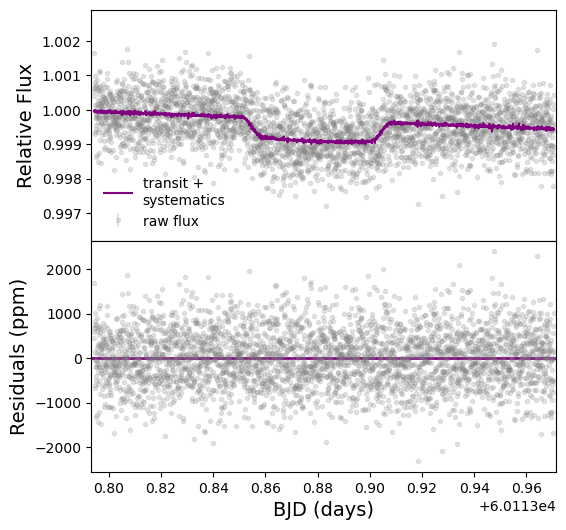

sys_fit values =  [ 1.77108000e+02 -1.63674156e+00 -2.92957793e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.02595242492068025 +- 0.0005024286216020799
Transit depth=0.0006735283592635452 +- 2.6078482160257687e-05
t0=60113.879878075466 +- 0.00043456566838445644
Residuals=590.2593005077304 ppm


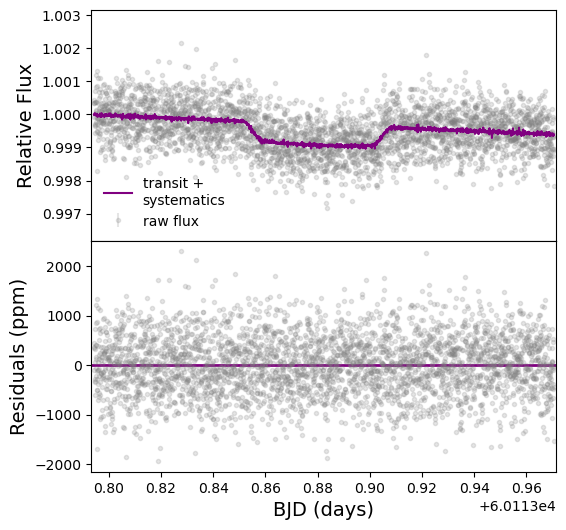

sys_fit values =  [ 2.06457416e+02 -2.08018683e+00 -3.41780828e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.024949398094081875 +- 0.0004990340791273268
Transit depth=0.0006224724652569763 +- 2.4901199805322462e-05
t0=60113.879640188425 +- 0.000441468757383929
Residuals=564.1974559415053 ppm
Rp/Rs=0.024949398094081875 +- 0.0004990340791273268
Transit depth=0.0006224724652569763 +- 2.4901199805322462e-05
t0=60113.879640188425 +- 0.000441468757383929
Residuals=564.1974559415053 ppm


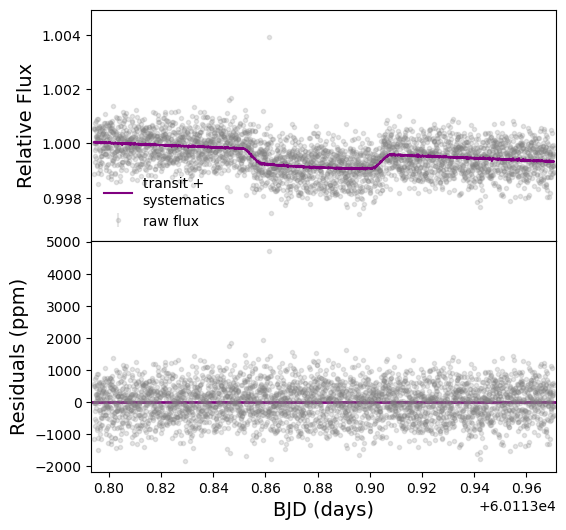

sys_fit values =  [ 2.43156255e+02 -9.04634384e-01 -4.02829691e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.025929921549807125 +- 0.0004682560204876694
Transit depth=0.0006723608315791519 +- 2.428368375294029e-05
t0=60113.87997844876 +- 0.0004047261855752281
Residuals=549.9247694375445 ppm


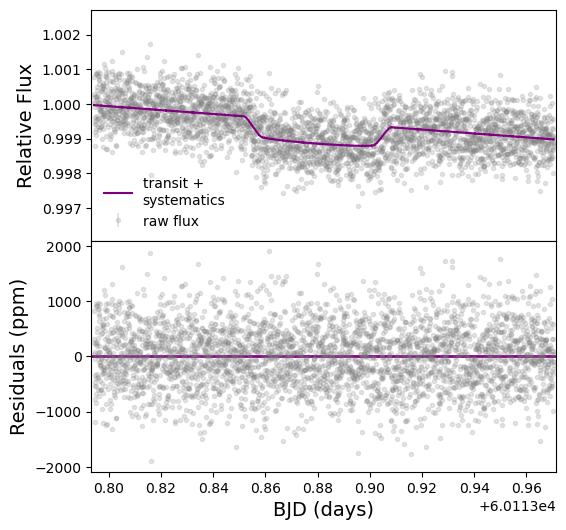

sys_fit values =  [ 3.38554354e+02 -1.21928327e-01 -5.61525674e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.026543121417184685 +- 0.0004449527146145044
Transit depth=0.0007045372945674083 +- 2.3620867857837434e-05
t0=60113.8799675066 +- 0.00037892782518321845
Residuals=534.951807307756 ppm


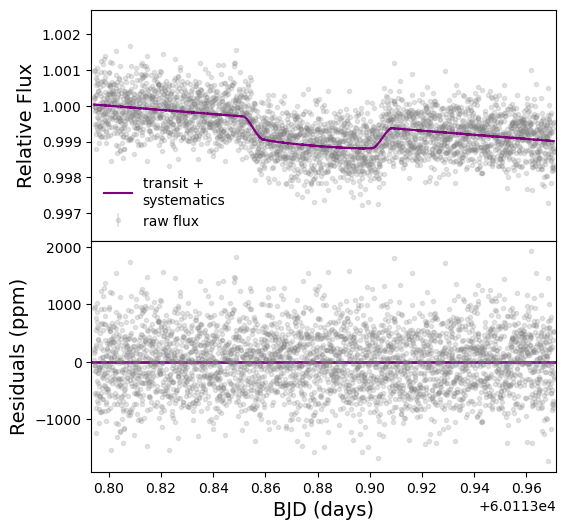

sys_fit values =  [ 3.49562022e+02 -1.92871195e-01 -5.79836946e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.02650144482115045 +- 0.00043787189005355944
Transit depth=0.000702326577608482 +- 2.3208475465974523e-05
t0=60113.8807167753 +- 0.00037306409509559177
Residuals=526.1547090476578 ppm


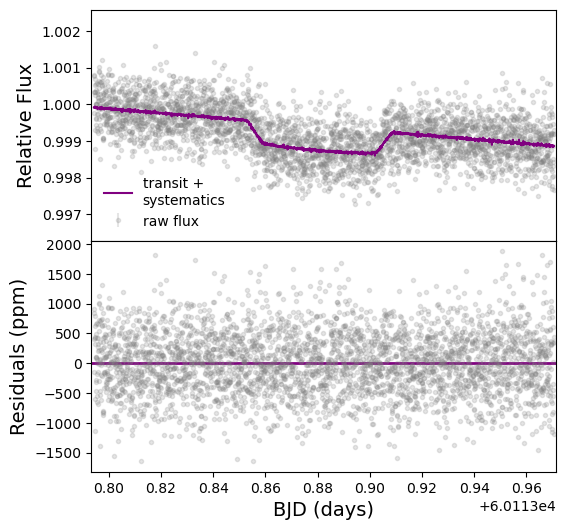

sys_fit values =  [ 3.60566898e+02 -1.21199847e+00 -5.98143886e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.02566447706375123 +- 0.0004503490354852119
Transit depth=0.000658665382955813 +- 2.3115944983785418e-05
t0=60113.879618451734 +- 0.0003908679396127632
Residuals=525.7024365408529 ppm


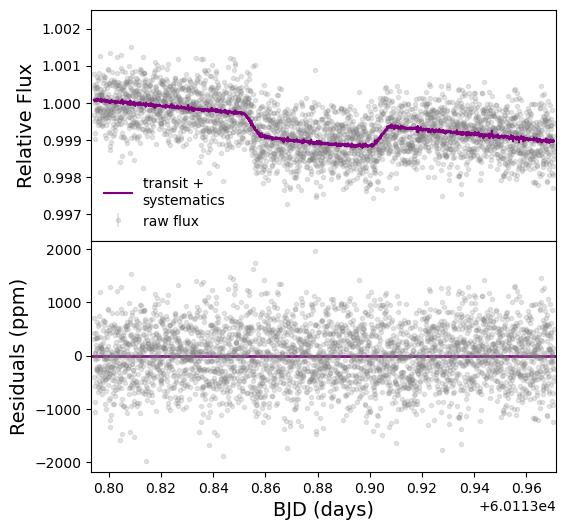

sys_fit values =  [ 3.82585231e+02  1.50048752e+00 -6.34771365e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.025503738177912485 +- 0.0004569150034340432
Transit depth=0.0006504406610475109 +- 2.3306081234283643e-05
t0=60113.8804461232 +- 0.00039866346483428776
Residuals=530.2829809125137 ppm


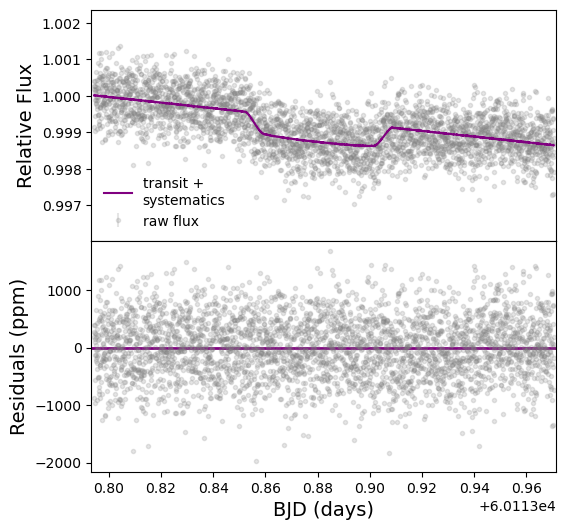

sys_fit values =  [ 4.66973681e+02  2.64187886e-01 -7.75152643e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.026749041462237288 +- 0.00044046563698956767
Transit depth=0.0007155112191484896 +- 2.3564067173049407e-05
t0=60113.87992877457 +- 0.0003733499782556978
Residuals=535.596785532482 ppm


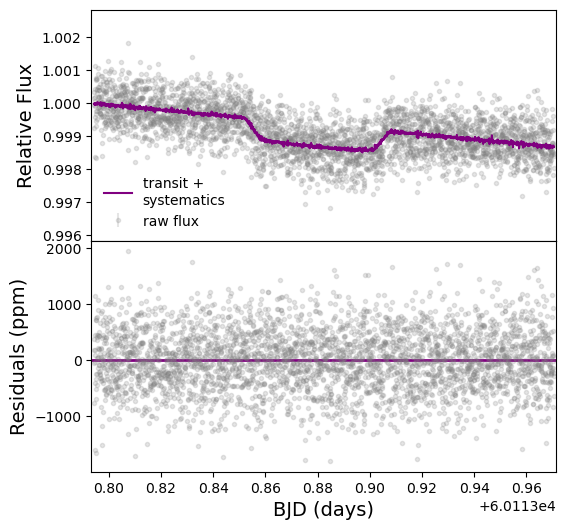

sys_fit values =  [ 4.48629057e+02  1.94172323e+00 -7.44636186e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.025954750782649697 +- 0.0004537203024483362
Transit depth=0.0006736490881894551 +- 2.3552394750150022e-05
t0=60113.87994156078 +- 0.00039122826559609186
Residuals=537.6313686129685 ppm
Rp/Rs=0.025954750782649697 +- 0.0004537203024483362
Transit depth=0.0006736490881894551 +- 2.3552394750150022e-05
t0=60113.87994156078 +- 0.00039122826559609186
Residuals=537.6313686129685 ppm


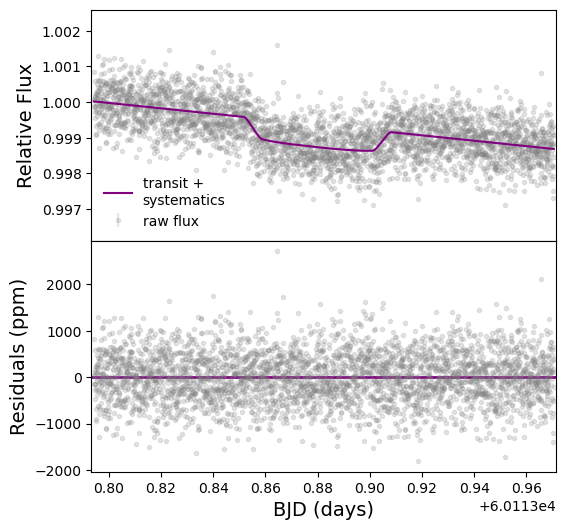

sys_fit values =  [ 4.55964831e+02 -1.00838025e-02 -7.56839285e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.025329709163927835 +- 0.0004440756165405418
Transit depth=0.0006415941663291697 +- 2.249661242752773e-05
t0=60113.88015391049 +- 0.0003881630298439028
Residuals=515.819468022107 ppm


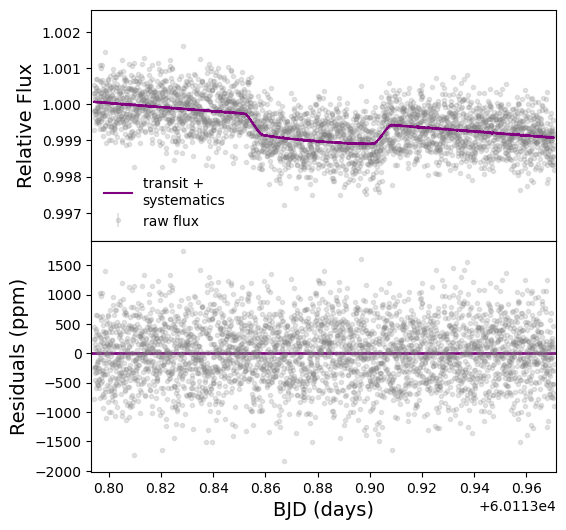

sys_fit values =  [ 3.38553812e+02 -4.48281620e-01 -5.61524611e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.025666728135003904 +- 0.00044996268765293046
Transit depth=0.0006587809331562009 +- 2.309813994976689e-05
t0=60113.880637272494 +- 0.00038991356207301783
Residuals=530.7922354003407 ppm
Rp/Rs=0.025666728135003904 +- 0.00044996268765293046
Transit depth=0.0006587809331562009 +- 2.309813994976689e-05
t0=60113.880637272494 +- 0.00038991356207301783
Residuals=530.7922354003407 ppm


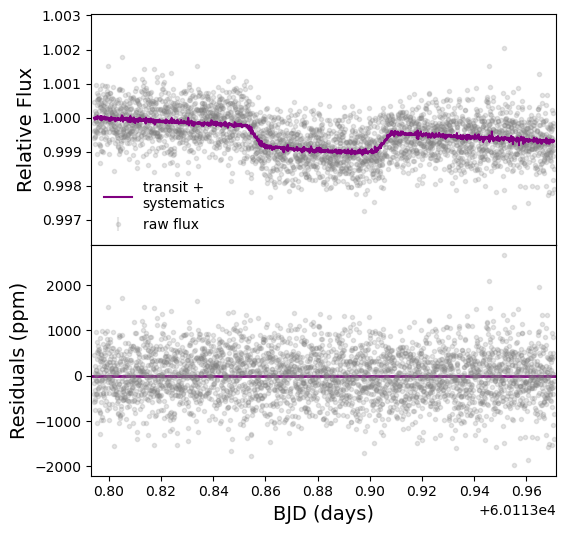

sys_fit values =  [ 2.35809509e+02  2.20317537e+00 -3.90608375e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.025582623568994028 +- 0.00045956050361142814
Transit depth=0.0006544706286728487 +- 2.3513526742136972e-05
t0=60113.880699803274 +- 0.0003988121349907752
Residuals=541.4116212542107 ppm


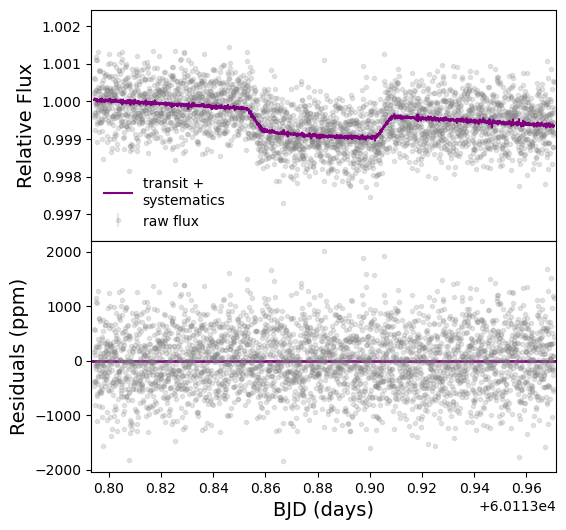

sys_fit values =  [ 2.35814325e+02 -1.61002294e+00 -3.90616312e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.02531836639765908 +- 0.00046881265702475127
Transit depth=0.0006410196770461125 +- 2.3739141244825468e-05
t0=60113.88020136942 +- 0.00040815507270674996
Residuals=549.2941795592735 ppm


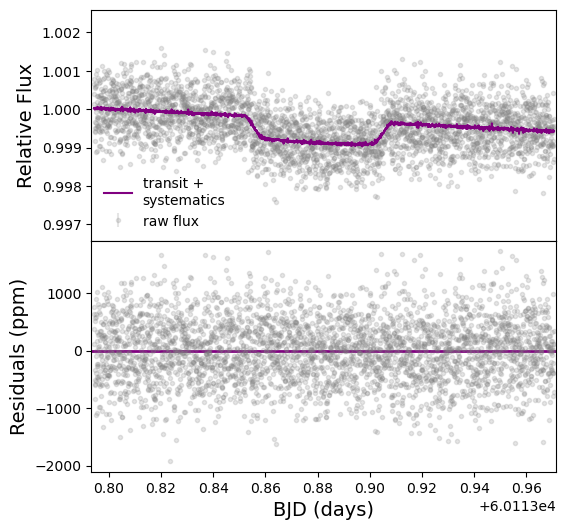

sys_fit values =  [ 2.06463969e+02  1.42311591e+00 -3.41791674e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.025968506082059927 +- 0.00045162274898047263
Transit depth=0.0006743633081339835 +- 2.3455936207392055e-05
t0=60113.88038442051 +- 0.0003861948500429926
Residuals=544.0992882893751 ppm


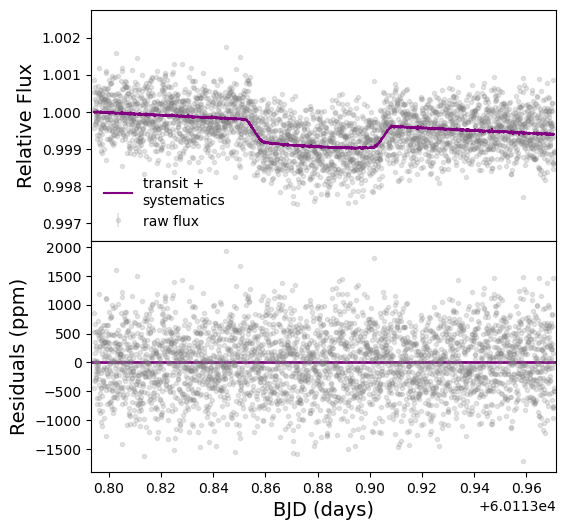

sys_fit values =  [ 2.06466618e+02  7.72080273e-01 -3.41796129e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.025206749584739306 +- 0.0004751943739796751
Transit depth=0.0006353802246277551 +- 2.3956211177965257e-05
t0=60113.8802026124 +- 0.00041334040062239805
Residuals=557.2088923013735 ppm


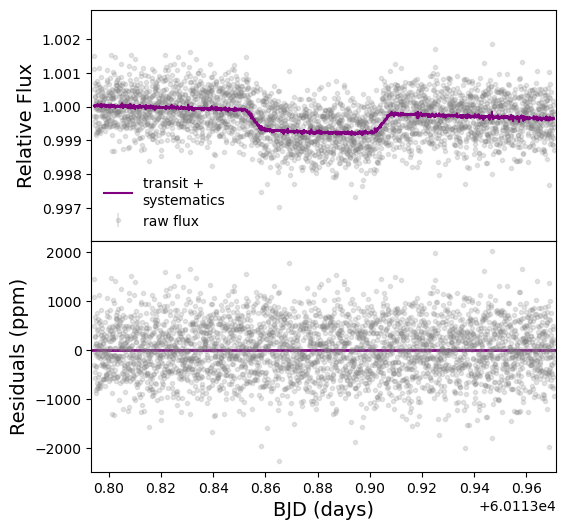

sys_fit values =  [ 1.33082609e+02  1.67696552e+00 -2.19720911e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.026155075649241816 +- 0.0004607923759190944
Transit depth=0.0006840879822175623 +- 2.4104118901515578e-05
t0=60113.88084430008 +- 0.00039134059993477965
Residuals=561.2956651160491 ppm


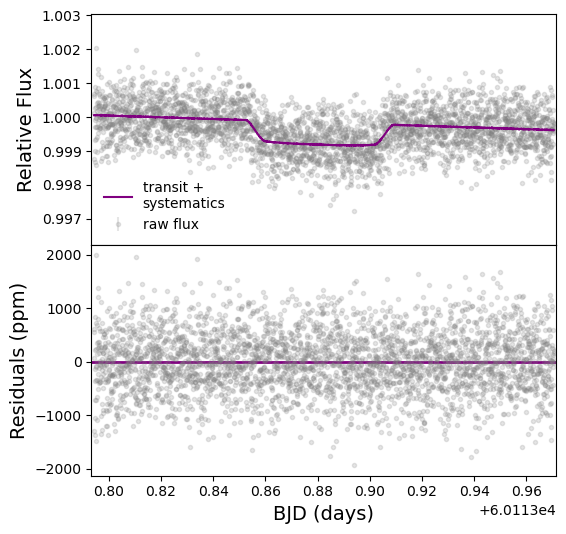

sys_fit values =  [ 1.51431281e+02  2.82383395e-01 -2.50244095e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.02559930184630824 +- 0.0004841407890842552
Transit depth=0.0006553242550184005 +- 2.4787332391755408e-05
t0=60113.87967776049 +- 0.0004152219008234199
Residuals=577.2096515697824 ppm
Rp/Rs=0.02559930184630824 +- 0.0004841407890842552
Transit depth=0.0006553242550184005 +- 2.4787332391755408e-05
t0=60113.87967776049 +- 0.0004152219008234199
Residuals=577.2096515697824 ppm


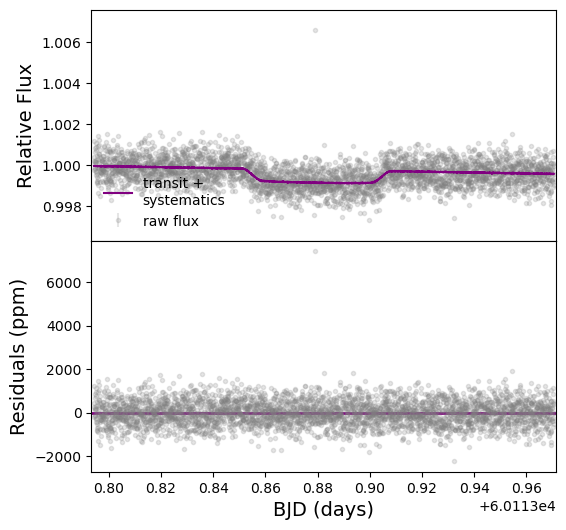

sys_fit values =  [ 1.33084722e+02 -6.27796880e-01 -2.19724538e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.02492015873798815 +- 0.00048346059757056834
Transit depth=0.0006210143115265272 +- 2.4095829670042343e-05
t0=60113.8798340197 +- 0.00042094872571484454
Residuals=564.4484077060997 ppm


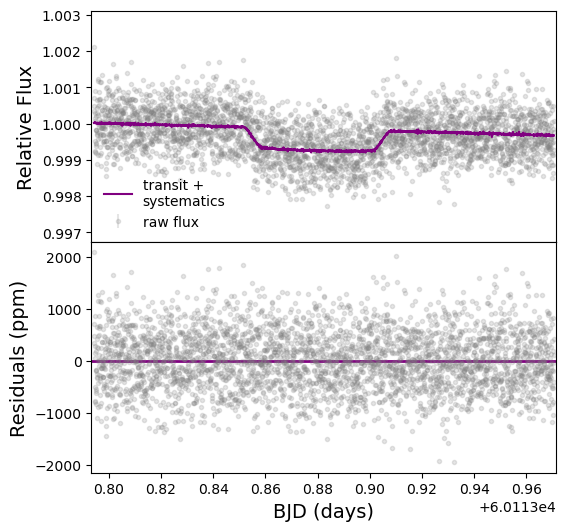

sys_fit values =  [ 1.18406473e+02 -1.01665139e+00 -1.95307012e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.025070201552515863 +- 0.00048254779829656525
Transit depth=0.0006285150058837688 +- 2.419514112403532e-05
t0=60113.87979621267 +- 0.00041787000636911984
Residuals=567.8100482469972 ppm


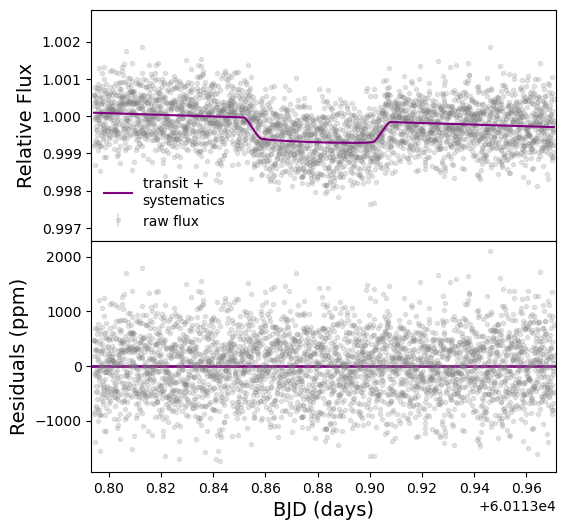

sys_fit values =  [ 1.33086271e+02  2.18479331e-02 -2.19726904e-03  0.00000000e+00
  0.00000000e+00]

Rp/Rs=0.025788280002364716 +- 0.0004817513025156889
Transit depth=0.0006650353854803639 +- 2.4847074961556993e-05
t0=60113.88094912753 +- 0.0004096309975996797
Residuals=583.6635547827841 ppm


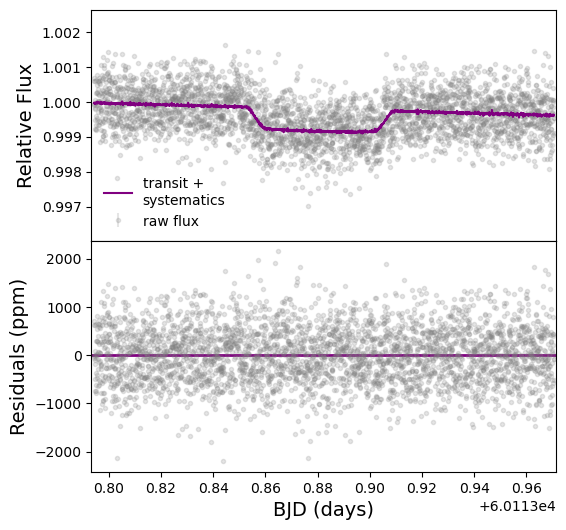

sys_fit values =  [ 1.22077722e+02  1.20149521e+00 -2.01414262e-03  0.00000000e+00
  0.00000000e+00]


,bin_start,bin_end,RpRs,RpRs_err,slope,slope_err
0,2.862704,2.903259,0.025780,0.000538,-0.002930,0.000215
1,2.903259,2.943814,0.025952,0.000502,-0.003418,0.000203
2,2.943814,2.984369,0.024949,0.000499,-0.004028,0.000194
3,2.984369,3.024923,0.025930,0.000468,-0.005615,0.000189
4,3.024923,3.065478,0.026543,0.000445,-0.005798,0.000184
5,3.065478,3.106033,0.026501,0.000438,-0.005981,0.000181
6,3.106033,3.146588,0.025664,0.000450,-0.006348,0.000181
7,3.146588,3.187143,0.025504,0.000457,-0.007752,0.000182
8,3.187143,3.227698,0.026749,0.000440,-0.007446,0.000184
9,3.227698,3.268253,0.025955,0.000454,-0.007568,0.000185


In [22]:
wlmin = 2.862704
wlmax = 3.714356

fit_nrs1(spec_file, wlmin, wlmax, save_dir)        
